In [3]:
import boto3
import pandas as pd
from multiprocessing import Pool
import multiprocessing
from sklearn.preprocessing import scale
from datetime import date, datetime, timedelta 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import time

#!conda install -c conda-forge pygrib -n tensorflow_p36 -y
import tensorflow
import keras
import pygrib

from keras.layers.core import Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Model, Sequential 
from keras.layers import Dropout, Input
from keras import optimizers
import keras.backend as K

#!conda install -c conda-forge eli5 -n tensorflow_p36 -y
#import eli5
#from eli5.sklearn import PermutationImportance

In [4]:
hours = np.arange(24)
fxx = [0]
field = 'prs'
model = 'hrrr'
sDATE = date(2017, 1, 1)          # Start date
eDATE = date(2017, 12, 31)          # End date (exclusive)
days = (eDATE-sDATE).days
DATES = [sDATE + timedelta(days=d) for d in range(days)]


# for d in [DATES[0], DATES[1]]:
#     for h in np.arange(0,24):
#         path_grb2 = "../efs/%s_%s.t%02dz.wrf%sf%02d.grib2" % (d.strftime('%Y%m%d'), model, h, field, fxx[0])
#         bucket_name = 'jedi-pub'
#         key_data = 'remi/' + "%s_%s.t%02dz.wrf%sf%02d.grib2" % (d.strftime('%Y%m%d'), model, h, field, fxx[0])
#         s3 = boto3.resource('s3')
#         s3.Bucket(bucket_name).download_file(key_data, path_grb2)

In [5]:
#Function which return a matrix with all date from an hour
def one_hour_mat(d, model, hour, field, forecast):
    var_name = ['']*686
    mat_res = np.zeros((1905141,686))
    #mat_res = np.zeros((19052,686))
    path_grb2 = "../efs/%s_%s.t%02dz.wrf%sf%02d.grib2" % (d.strftime('%Y%m%d'), model, hour, field, forecast)
    grbs = pygrib.open(path_grb2)
    for j in range(684):
        grb = grbs.readline()
        var_name[j] = grb.name
        mat_res[:,j] =  grb.values.flatten()#[::100]
    lats, lons = grb.latlons()    
    mat_res[:,684] = lats.flatten()#[::100]
    mat_res[:,685] = lons.flatten()#[::100]
#     var_indices = np.array([i for i in range(np.shape(mat_res)[1]-6)])
#     var_indices = np.append(var_indices, [np.shape(mat_res)[1]-2,np.shape(mat_res)[1]-1])
#     resp_indices = [np.shape(mat_res)[1]-6,np.shape(mat_res)[1]-5,np.shape(mat_res)[1]-4,np.shape(mat_res)[1]-3]
#     mat_res[np.where( (mat_res[:,var_indices]==9.969209968386869e+36)  |  (mat_res[:,var_indices]==float('Inf')) )] = 0
#     resp_null_row_indices = np.where( (mat_res[:,resp_indices]==9.969209968386869e+36)  |  (mat_res[:,resp_indices]==float('Inf')) )[0]
#     mat_res = np.delete(mat_res, resp_null_row_indices,0)
    grbs.close()
    return (mat_res, np.array(var_name))

def one_hour_mat_2(d, model, hour, field, forecast):
    var_name = ['']*686
    path_grb2 = "../efs/%s_%s.t%02dz.wrf%sf%02d.grib2" % (d.strftime('%Y%m%d'), model, hour, field, forecast)
    mat_res_var = np.zeros((1905141,682))
    mat_res_target = np.zeros((1905141,4))
    #mat_res_var = np.zeros((19052,682))
    #mat_res_target = np.zeros((19052,4))
    grbs = pygrib.open(path_grb2)
    for j in range(680):
        grb = grbs.readline()
        mat_res_var[:,j] =  grb.values.flatten()#[::100]
    for j in np.array([680,681,682,683]):
        grb = grbs.readline()
        mat_res_target[:,j-680] = grb.values.flatten()#[::100]
    lats, lons = grb.latlons()    
    mat_res_var[:,680] = lats.flatten()#[::100]
    mat_res_var[:,681] = lons.flatten()#[::100]
    mat_res_var[np.where( (mat_res_var==9.969209968386869e+36)  |  (mat_res_var==float('Inf')) )] = 0
    resp_indices = np.array([0,1,2,3])
    resp_null_row_indices = np.where( (mat_res_target[:,resp_indices]==9.969209968386869e+36)  |  (mat_res_target[:,resp_indices]==float('Inf')) )[0]
    mat_res_target = np.delete(mat_res_target, resp_null_row_indices,0)
    mat_res_var = np.delete(mat_res_var, resp_null_row_indices,0)
    grbs.close()
    return (mat_res_var, mat_res_target, np.array(var_name))

#Function to scale matrices
def scale_matrices(X_train, y_train, X_test, y_test, X_valid=None, y_valid=None):
    #y_train = np.reshape(y_train, (-1,1))
    #y_test = np.reshape(y_test, (-1,1))
    #if (y_valid is not None):
    #    y_valid = np.reshape(y_valid, (-1,1))
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    if (X_valid is not None):
        X_valid = scaler.transform(X_valid)
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    if (y_valid is not None):
        y_valid = scaler.transform(y_valid)
    if (y_valid is not None):      
        return(X_train, X_test, y_train, y_test, X_valid, y_valid, scaler)    
    else:
        return(X_train, X_test, y_train, y_test, scaler)    

In [6]:
start = time.time()
X_train, y_train, var_name = one_hour_mat_2(d, model, 0, field, fxx[0])
# for h in np.arange(1,6):
#     vard, targd, var = one_hour_mat_2(d, model, h, field, fxx[0])
#     print(vard.shape)
#     print(targd.shape)
#     X_train = np.append(X_train, vard, axis=0)
#     y_train = np.append(y_train, targd, axis=0)
#     print(X_train.shape)
#     print(y_train.shape)
end = time.time()
print(end-start)

print(X_train.shape)
print(y_train.shape)

59.58887553215027
(1809048, 682)
(1809048, 4)


In [7]:
#Prepare matrices
start = time.time()
scaler_X= StandardScaler()
scaler_X.fit(X_train)
X_train = scaler_X.transform(X_train)
scaler_Y= StandardScaler()
scaler_Y.fit(y_train)
y_train = scaler_Y.transform(y_train)
end = time.time()
print(end-start)

print(X_train.shape)
print(y_train.shape)

43.79030156135559
(1809048, 682)
(1809048, 4)


In [8]:
#Neural networks
def rmse_loss(yTrue, yPred):
    return K.sqrt(keras.losses.mean_squared_error(yTrue,yPred))

def dense_Model(dense_size, output_size=4,optimizer_='adam'):
    model = Sequential()
    #model.add(Dense(dense_size*2, activation='linear'))
    #model.add(Dense(16, activation='tanh'))
    model.add(Dense(500, activation='tanh'))
    model.add(Dense(500, activation='tanh'))
    model.add(Dense(output_size, activation='linear'))
    model.compile(loss=rmse_loss, optimizer=optimizer_, metrics=['mae', 'acc'])
    return model

In [9]:
nn=dense_Model(dense_size=8, optimizer_=optimizers.Adam(lr=0.001), output_size=4)
start = time.time()
nn.fit(X_train, y_train, verbose=1, epochs=50, batch_size=1000)
end = time.time()
print(end-start)

Epoch 1/50
1809048/1809048 [==============================] - 24s 13us/step - loss: 0.0814 - mean_absolute_error: 0.0694 - acc: 0.9046
Epoch 2/50
1809048/1809048 [==============================] - 23s 13us/step - loss: 0.0492 - mean_absolute_error: 0.0419 - acc: 0.9412
Epoch 3/50
1809048/1809048 [==============================] - 24s 13us/step - loss: 0.0411 - mean_absolute_error: 0.0350 - acc: 0.9534
Epoch 4/50
1809048/1809048 [==============================] - 23s 13us/step - loss: 0.0361 - mean_absolute_error: 0.0309 - acc: 0.9610
Epoch 5/50
1809048/1809048 [==============================] - 23s 13us/step - loss: 0.0324 - mean_absolute_error: 0.0277 - acc: 0.9661
Epoch 6/50
1809048/1809048 [==============================] - 23s 13us/step - loss: 0.0302 - mean_absolute_error: 0.0259 - acc: 0.9690
Epoch 7/50
1809048/1809048 [==============================] - 23s 13us/step - loss: 0.0285 - mean_absolute_error: 0.0245 - acc: 0.9708
Epoch 8/50
1809048/1809048 [===========================

In [10]:
y_predict =  nn.predict(X_train)
print(mean_squared_error(y_predict, y_train))

y_pred_unscale = scaler_Y.inverse_transform(y_predict)
y_true_unscale = scaler_Y.inverse_transform(y_train)

print(np.sqrt(mean_squared_error(y_pred_unscale[:,0], y_true_unscale[:,0])))
print(np.sqrt(mean_squared_error(y_pred_unscale[:,1], y_true_unscale[:,1])))
print(np.sqrt(mean_squared_error(y_pred_unscale[:,2], y_true_unscale[:,2])))
print(np.sqrt(mean_squared_error(y_pred_unscale[:,3], y_true_unscale[:,3])))

0.0009603377680620613
0.1592520003788457
0.49552255622859787
0.14899269469007373
0.5434843902179807


In [11]:
err_abs_y0 = np.abs(y_pred_unscale[:,0] - y_true_unscale[:,0])

In [13]:
mat_tot = one_hour_mat(d, model, 0, field, fxx[0])[0]

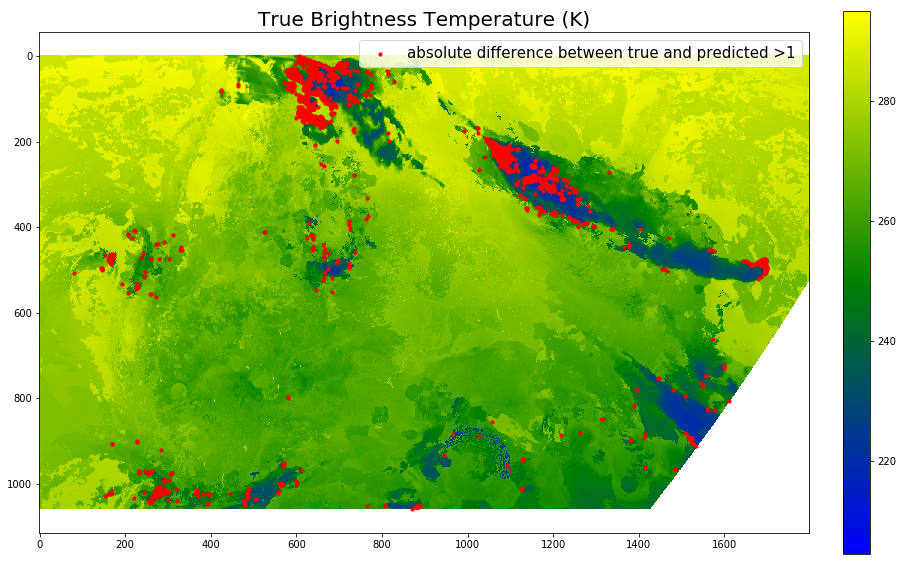

In [14]:
from matplotlib.colors import LinearSegmentedColormap

resp_notnull_ind = np.where( (mat_tot[:,683]!=9.969209968386869e+36)  &  (mat_tot[:,683]!=float('Inf')) )[0]
true_tb = np.zeros((1059,1799)).flatten()
true_tb[resp_notnull_ind] = mat_tot[resp_notnull_ind,683]

mask = np.ones(true_tb.shape, dtype=bool)
mask[resp_notnull_ind] = False
true_tb = np.ma.masked_array(true_tb, mask)

plt.figure(figsize=(15,10))
colors = ['blue', 'green', 'yellow']  # R -> G -> B
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
    cmap_name, colors)
plt.imshow(true_tb.reshape(1059,1799), cmap = cm)

plt.colorbar(fraction=0.040, pad=0.04)

errabs_tb = np.zeros((1059,1799)).flatten()
errabs_tb[resp_notnull_ind] = err_abs_y0

err_val_ind = np.where(errabs_tb.reshape(1059,1799) >1)
plt.scatter(err_val_ind[1], err_val_ind[0],s=10, color='red', label='absolute difference between true and predicted >1')
plt.legend(prop={'size': 15})
plt.title('True Brightness Temperature (K)', size=20)

plt.savefig('true_BT_errors')

In [ ]:
start = time.time()
RMSE_list_y1 = list()
RMSE_list_y2 = list()
RMSE_list_y3 = list()
RMSE_list_y4 = list()

for d in [DATES[0], DATES[1]]:
    for h in np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]):
        print(h)
        X_test, y_test, var_name = one_hour_mat_2(d, model, h, field, fxx[0])

        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)
        scaler = StandardScaler()
        y_test = scaler.fit_transform(y_test)

        y_predict = nn.predict(X_test)
        y_pred_unscale = scaler_Y.inverse_transform(y_predict)
        y_true_unscale = scaler_Y.inverse_transform(y_test)
        del X_test
        del y_test
        del y_predict
        print('scale')

        RMSE_list_y1.append(np.sqrt(mean_squared_error(y_pred_unscale[:,0], y_true_unscale[:,0])))
        RMSE_list_y2.append(np.sqrt(mean_squared_error(y_pred_unscale[:,1], y_true_unscale[:,1])))
        RMSE_list_y3.append(np.sqrt(mean_squared_error(y_pred_unscale[:,2], y_true_unscale[:,2])))
        RMSE_list_y4.append(np.sqrt(mean_squared_error(y_pred_unscale[:,3], y_true_unscale[:,3])))
    
end = time.time()
print(end-start)

In [ ]:
print('mean',np.mean(RMSE_list_y1))
print('std',np.std(RMSE_list_y1))
print('mean',np.mean(RMSE_list_y2))
print('std',np.std(RMSE_list_y2))
print('mean',np.mean(RMSE_list_y3))
print('std',np.std(RMSE_list_y3))
print('mean',np.mean(RMSE_list_y4))
print('std',np.std(RMSE_list_y4))

In [ ]:
RMSE_list_y1

In [ ]:
RMSE_list_y2

In [ ]:
RMSE_list_y3

In [ ]:
RMSE_list_y4